In [1]:
import pandas as pd
import numpy as np
import hvplot.pandas
import pickle
from collections import defaultdict

import math
import matplotlib

import mplcyberpunk
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import style
from datetime import datetime
from datetime import timezone
from pylab import rcParams
from matplotlib import rc
from tqdm.notebook import tqdm
import pytz

from sklearn.preprocessing import MinMaxScaler
style.use('cyberpunk')

In [2]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.10.1


In [3]:
#하이퍼파라미터
batch_size = 32
seq_len = 120

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [140]:
data = pd.read_csv('5Y_naver_stock.csv')

In [141]:
data['date'] = data['date'].apply(pd.to_datetime)
data['date'] = data['date'].dt.tz_localize(None)
data = data.set_index(data['date'])

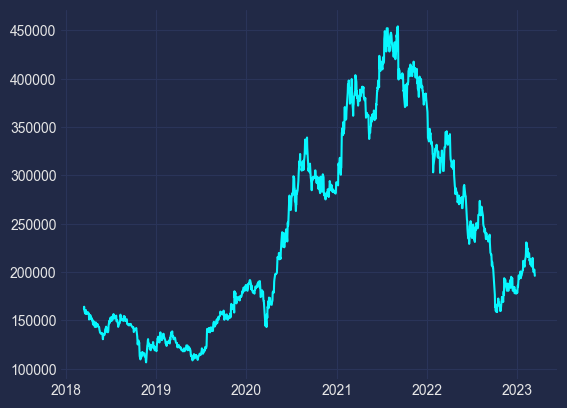

In [142]:
plt.plot(data.close)
plt.show()

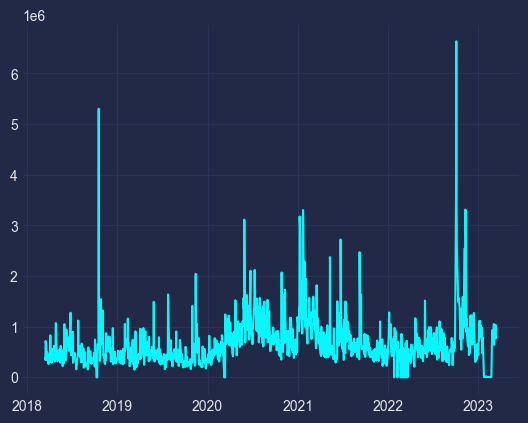

In [143]:
plt.plot(data.volume)
plt.show()

In [8]:
data.columns

Index(['date', 'date.1', 'open', 'high', 'low', 'close', 'volume',
       'open_mean_lag3', 'open_mean_lag7', 'open_mean_lag30', 'open_std_lag3',
       'open_std_lag7', 'open_std_lag30', 'high_mean_lag3', 'high_mean_lag7',
       'high_mean_lag30', 'high_std_lag3', 'high_std_lag7', 'high_std_lag30',
       'low_mean_lag3', 'low_mean_lag7', 'low_mean_lag30', 'low_std_lag3',
       'low_std_lag7', 'low_std_lag30', 'close_mean_lag3', 'close_mean_lag7',
       'close_mean_lag30', 'close_std_lag3', 'close_std_lag7',
       'close_std_lag30', 'volume_mean_lag3', 'volume_mean_lag7',
       'volume_mean_lag30', 'volume_std_lag3', 'volume_std_lag7',
       'volume_std_lag30', 'month', 'week', 'day', 'day_of_week',
       '1st diff_close'],
      dtype='object')

In [21]:
# close에 알맞는 변수 리스트
exogenous_features = ['open_mean_lag3',
                      'open_mean_lag7', 'open_mean_lag30', 'open_std_lag3', 'open_std_lag7',
                      'open_std_lag30', 'high_mean_lag3', 'high_mean_lag7', 'high_mean_lag30',
                      'high_std_lag3', 'high_std_lag7', 'high_std_lag30', 'low_mean_lag3',
                      'low_mean_lag7', 'low_mean_lag30', 'low_std_lag3', 'low_std_lag7',
                      'low_std_lag30', 'close_mean_lag3', 'close_mean_lag7',
                      'close_mean_lag30', 'close_std_lag3', 'close_std_lag7',
                      'close_std_lag30', 'volume_mean_lag3', 'volume_mean_lag7',
                      'volume_mean_lag30', 'volume_std_lag3',
                      'volume_std_lag7', 'volume_std_lag30', 'month', 'week',
                      'day', 'day_of_week','volume']

In [9]:
exogenous_features = ['open', 'high', 'low', 'volume',
                      'open_mean_lag30','high_mean_lag30','low_mean_lag30','close_mean_lag30']

In [10]:
#다른것들도 시도
# data['open'] = data['open'].pct_change()
# data['high'] = data['high'].pct_change() 
# data['low'] = data['low'].pct_change()
# data['close'] = data['close'].pct_change() 
# data['volume'] = data['volume'].pct_change()
# data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

In [11]:
data = data[exogenous_features + ['close']] 
data["prev_close"] = data.shift(1)["close"]
data["close_change"] = data.apply(lambda row: 0  if np.isnan(row.prev_close) else row.close - row.prev_close,
                                   axis = 1)
data.drop('prev_close', axis=1, inplace=True)

In [12]:
split_ratio = 0.9
train_size = int(len(data) * split_ratio)
print(len(data))
print(train_size)

1231
1107


In [13]:
#중요
SEQUENCE_LENGTH = 120

In [14]:
train_df, test_df = data[:train_size-SEQUENCE_LENGTH], data[train_size-SEQUENCE_LENGTH:]
train_df.shape, test_df.shape

((987, 10), (244, 10))

In [15]:
train_df

open      high       low  volume  open_mean_lag30  \
date                                                                
2018-03-14  162600.0  162800.0  160200.0  376640    236267.715622   
2018-03-15  162600.0  164800.0  161400.0  341525    162600.000000   
2018-03-16  163200.0  163400.0  159400.0  717990    162600.000000   
2018-03-19  160200.0  160400.0  156400.0  600070    162800.000000   
2018-03-20  155400.0  159200.0  154800.0  441955    162150.000000   
...              ...       ...       ...     ...              ...   
2022-03-14  328500.0  338000.0  325000.0  679812    318466.666667   
2022-03-15  329000.0  329000.0  329000.0       0    318316.666667   
2022-03-16  329000.0  329000.0  329000.0       0    318300.000000   
2022-03-17  329000.0  329000.0  329000.0       0    318533.333333   
2022-03-18  345000.0  346500.0  341500.0  722326    319266.666667   

            high_mean_lag30  low_mean_lag30  close_mean_lag30     close  \
date                                                                      
2018-03-14    239527.492445   232964.386217     236142.627796  161800.0   
2018-03-15    162800.000000   160200.000000     161800.000000  164000.0   
2018-03-16    163800.000000   160800.000000     162900.000000  160200.0   
2018-03-19    163666.666667   160333.333333     162000.000000  157000.0   
2018-03-20    162850.000000   159350.000000     160750.000000  159000.0   
...                     ...             ...               ...       ...   
2022-03-14    321283.333333   315550.000000     318500.000000  329000.0   
2022-03-15    321416.666667   315466.666667     318516.666667  329000.0   
2022-03-16    321333.333333   315833.333333     318750.000000  329000.0   
2022-03-17    321566.666667   316066.666667     318983.333333  329000.0   
2022-03-18    322016.666667   316933.333333     319850.000000  344500.0   

            close_change  
date                      
2018-03-14           0.0  
2018-03-15        2200.0  
2018-03-16       -3800.0  
2018-03-19       -3200.0  
2018-03-20        2000.0  
...                  ...  
2022-03-14       24500.0  
2022-03-15           0.0  
2022-03-16           0.0  
2022-03-17           0.0  
2022-03-18       15500.0  

[987 rows x 10 columns]

In [16]:
#정규화
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler()
scaler = scaler.fit(train_df[train_df.columns.difference(['close'])])
scaler2 = scaler2.fit(train_df['close'].values.reshape(-1,1))


train_df_scaler = train_df[train_df.columns.difference(['close'])]

train_df_scaler = pd.DataFrame(
    scaler.transform(train_df_scaler),
    index = train_df_scaler.index,
    columns = train_df_scaler.columns
)
train_df_scaler['close'] = scaler2.transform(train_df['close'].values.reshape(-1,1)).squeeze()

test_df_scaler = test_df[test_df.columns.difference(['close'])]

test_df_scaler = pd.DataFrame(
    scaler.transform(test_df_scaler),
    index = test_df_scaler.index,
    columns = test_df_scaler.columns
)
test_df_scaler['close'] = scaler2.transform(test_df['close'].values.reshape(-1,1)).squeeze()

In [17]:
# #volume칼럼을 끝자리로
if 'volume' in train_df_scaler.columns:
    train_volumes = train_df_scaler['volume'].to_list()
    test_volumes = test_df_scaler['volume'].to_list()

    train_df_scaler.drop(['volume'], axis=1, inplace=True)
    test_df_scaler.drop(['volume'], axis=1, inplace=True)

    train_df_scaler['volume'] = train_volumes
    test_df_scaler['volume'] = test_volumes

In [31]:
#날짜 칼럼 끝자리로
# train_month = train_df_scaler['month'].to_list()
# train_week = train_df_scaler['week'].to_list()
# train_day = train_df_scaler['day'].to_list()
# train_day_of_week = train_df_scaler['day_of_week'].to_list()

# test_month = test_df_scaler['month'].to_list()
# test_week = test_df_scaler['week'].to_list()
# test_day = test_df_scaler['day'].to_list()
# test_day_of_week = test_df_scaler['day_of_week'].to_list()

# train_df_scaler.drop(['month', 'week', 'day','day_of_week'], axis=1, inplace=True)
# test_df_scaler.drop(['month', 'week', 'day','day_of_week'], axis=1, inplace=True)

# train_df_scaler['month'] = train_month
# train_df_scaler['week'] = train_week
# train_df_scaler['day'] = train_day
# train_df_scaler['day_of_week'] = train_day_of_week

# test_df_scaler['month'] = test_month
# test_df_scaler['week'] = test_week
# test_df_scaler['day'] = test_day
# test_df_scaler['day_of_week'] = test_day_of_week

In [18]:
test_df_scaler

close_change  close_mean_lag30      high  high_mean_lag30  \
date                                                                    
2022-03-21      0.037037          0.277052  0.326816         0.262317   
2022-03-22     -0.111111          0.281952  0.307263         0.266037   
2022-03-23      0.214815          0.284402  0.343575         0.268349   
2022-03-24     -0.125926          0.288179  0.312849         0.272069   
2022-03-25     -0.170370          0.290833  0.301676         0.275085   
...                  ...               ...       ...              ...   
2023-03-08     -0.214815         -0.383830 -0.430168        -0.379147   
2023-03-09      0.022222         -0.382503 -0.446927        -0.377539   
2023-03-10     -0.028148         -0.382503 -0.474860        -0.377036   
2023-03-13      0.117037         -0.382952 -0.463687        -0.377639   
2023-03-15     -0.155556         -0.384790 -0.469274        -0.379348   

                 low  low_mean_lag30      open  open_mean_lag30     close  \
date                                                                        
2022-03-21  0.382184        0.285958  0.348378         0.273079  0.684892   
2022-03-22  0.333333        0.291019  0.322990         0.276949  0.670504   
2022-03-23  0.364943        0.294118  0.339915         0.280717  0.687770   
2022-03-24  0.327586        0.298456  0.320169         0.283670  0.671942   
2022-03-25  0.313218        0.300108  0.320169         0.286216  0.651799   
...              ...             ...       ...              ...       ...   
2023-03-08 -0.436782       -0.382740 -0.418900        -0.383064  0.276259   
2023-03-09 -0.436782       -0.381294 -0.441467        -0.380417  0.274820   
2023-03-10 -0.460920       -0.380798 -0.478138        -0.379602  0.268489   
2023-03-13 -0.479310       -0.381232 -0.467983        -0.380518  0.276259   
2023-03-15 -0.471264       -0.382761 -0.466855        -0.381476  0.257554   

              volume  
date                  
2022-03-21 -1.000000  
2022-03-22 -0.886414  
2022-03-23 -0.809630  
2022-03-24 -0.800920  
2022-03-25 -0.789227  
...              ...  
2023-03-08 -0.612774  
2023-03-09 -0.713327  
2023-03-10 -0.677731  
2023-03-13 -0.609573  
2023-03-15 -0.707270  

[244 rows x 10 columns]

In [19]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    x_sequences = []
    y_ = []
    data_size = len(input_data)
    
    for i in tqdm(range(data_size - sequence_length)):
        
        sequence = input_data[i: i+sequence_length]
        
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        x_sequences.append(sequence)
        y_.append(label)
    return x_sequences, y_

In [20]:
X_train, y_train = create_sequences(train_df_scaler, "close", SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_df_scaler, "close", SEQUENCE_LENGTH)

  0%|          | 0/867 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

In [21]:
X_train_, y_train_, X_test_, y_test_  = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [22]:
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((867, 120, 10), (867,), (124, 120, 10), (124,))

In [23]:
"""https://github.com/JanSchm/CapMarket"""

#Time2Vec
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)
        
        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)
        
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:10], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
      
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [24]:
## Transformer
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 37), input_shape[0][-1]= 37
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 37), input_shape[0][-1] = 37 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [25]:
#모델
def create_model(Input_shape):
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, Input_shape))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [26]:
len(train_df_scaler.columns)

10

In [27]:
model = create_model(Input_shape= X_train_.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 10)]    0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 120, 2)       480         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 120, 12)      0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 120, 12)     163144      ['concatenate[0][0]',        

In [28]:
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

In [29]:
history = model.fit(X_train_, y_train_, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_test_, y_test_))  

Epoch 1/35
28/28 [==============================] - ETA: 0s - loss: 0.1230 - mae: 0.2661
Epoch 1: val_loss improved from inf to 0.06551, saving model to Transformer+TimeEmbedding.hdf5
28/28 [==============================] - 45s 937ms/step - loss: 0.1230 - mae: 0.2661 - val_loss: 0.0655 - val_mae: 0.2145
Epoch 2/35
28/28 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0851
Epoch 2: val_loss did not improve from 0.06551
28/28 [==============================] - 20s 719ms/step - loss: 0.0115 - mae: 0.0851 - val_loss: 0.1378 - val_mae: 0.3529
Epoch 3/35
28/28 [==============================] - ETA: 0s - loss: 0.0089 - mae: 0.0724
Epoch 3: val_loss did not improve from 0.06551
28/28 [==============================] - 20s 713ms/step - loss: 0.0089 - mae: 0.0724 - val_loss: 0.1047 - val_mae: 0.2962
Epoch 4/35
28/28 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0699
Epoch 4: val_loss did not improve from 0.06551
28/28 [==============================] - 2

In [38]:
model = tf.keras.models.load_model('./Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

In [39]:
#Calculate predication for training
train_pred = model.predict(X_train_)
val_pred = model.predict(X_test_)

4/4 [==============================] - 1s 167ms/step


Model metrics

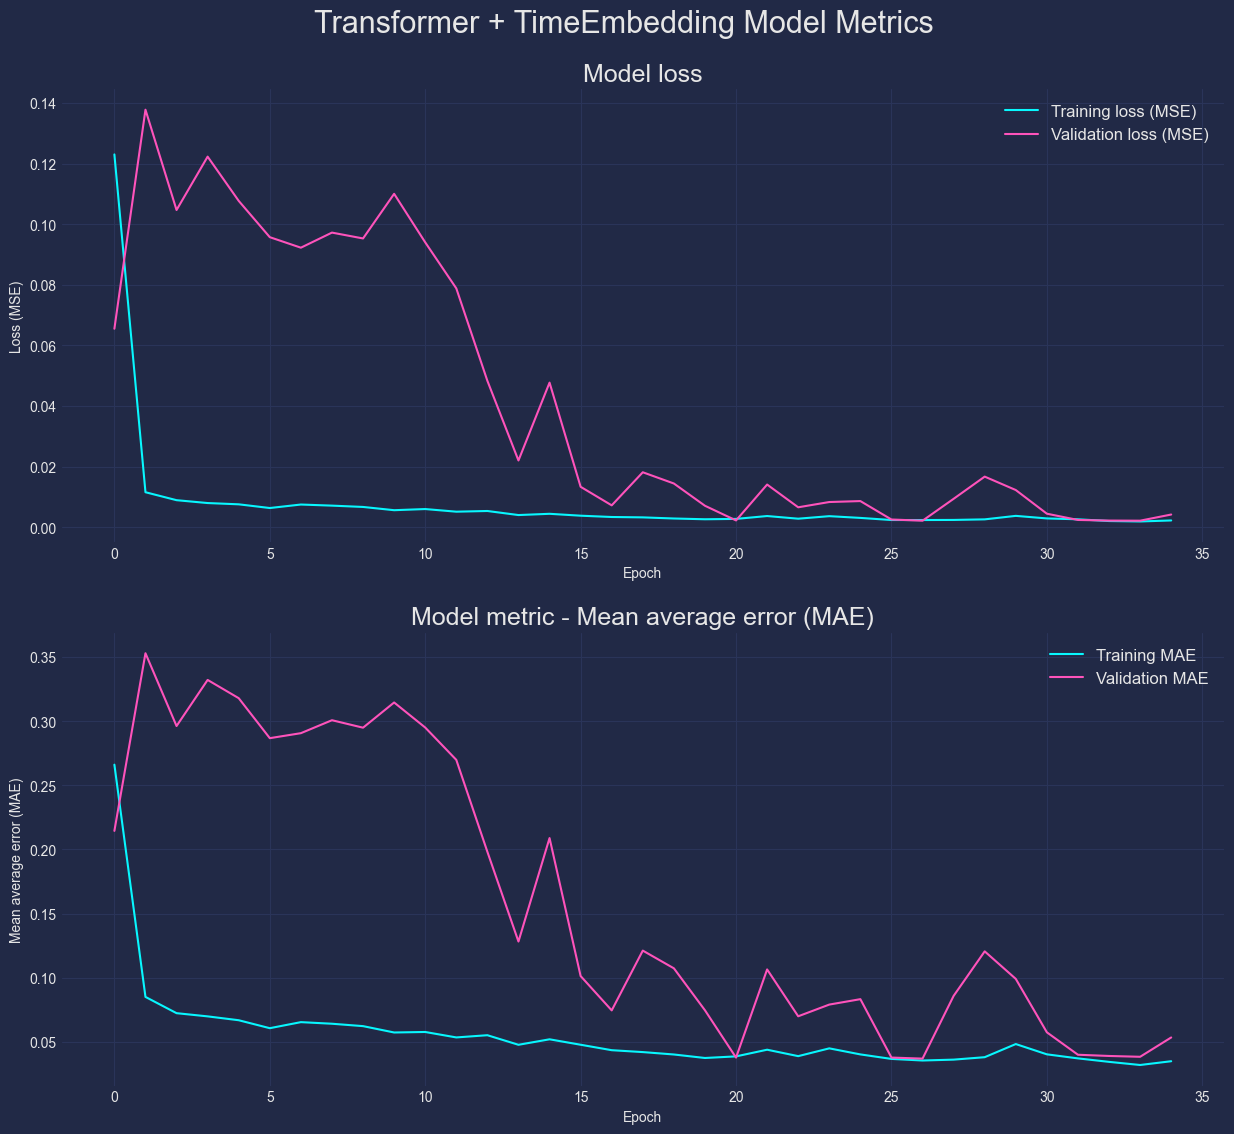

In [40]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

In [43]:
#train_df_test = train_df[:len(train_df)-90]
train_df_test = train_df[SEQUENCE_LENGTH:]

In [44]:
train_df_test['prediction'] = scaler2.inverse_transform(np.array(train_pred).reshape(-1,1)).squeeze()

<Axes: xlabel='date'>

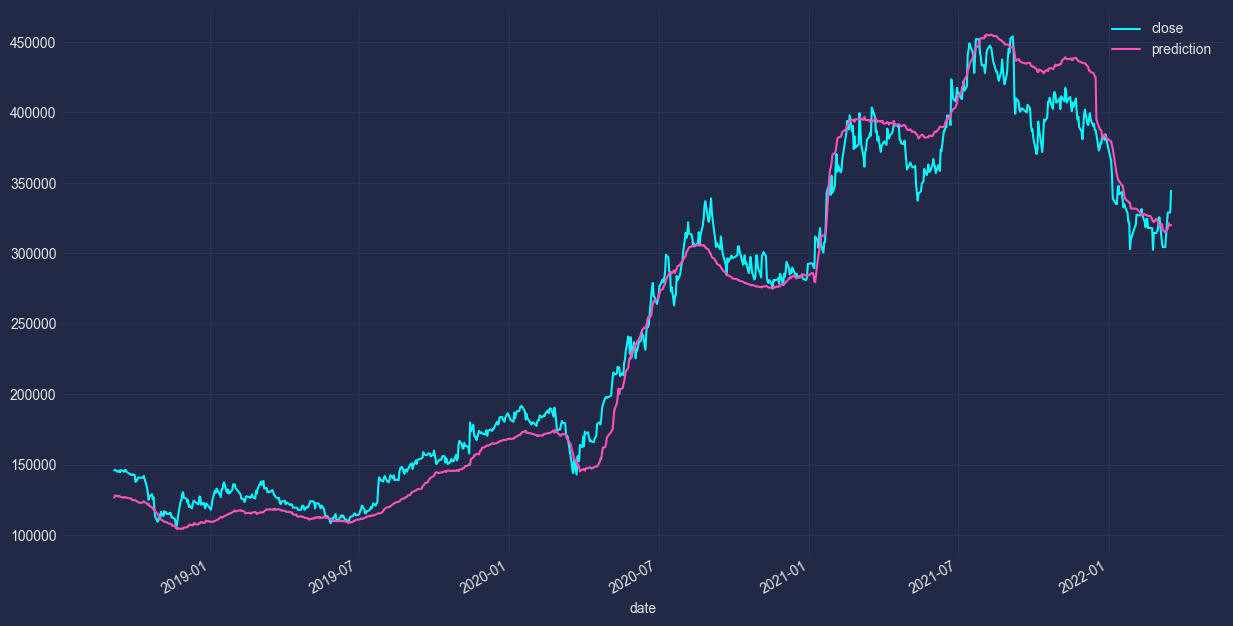

In [45]:
train_df_test[["close", "prediction"]].plot(figsize=(15, 8))

In [46]:
predict_test_df = test_df[SEQUENCE_LENGTH:]
predict_test_df['prediction'] = scaler2.inverse_transform(np.array(val_pred).reshape(-1,1)).squeeze()

<Axes: xlabel='date'>

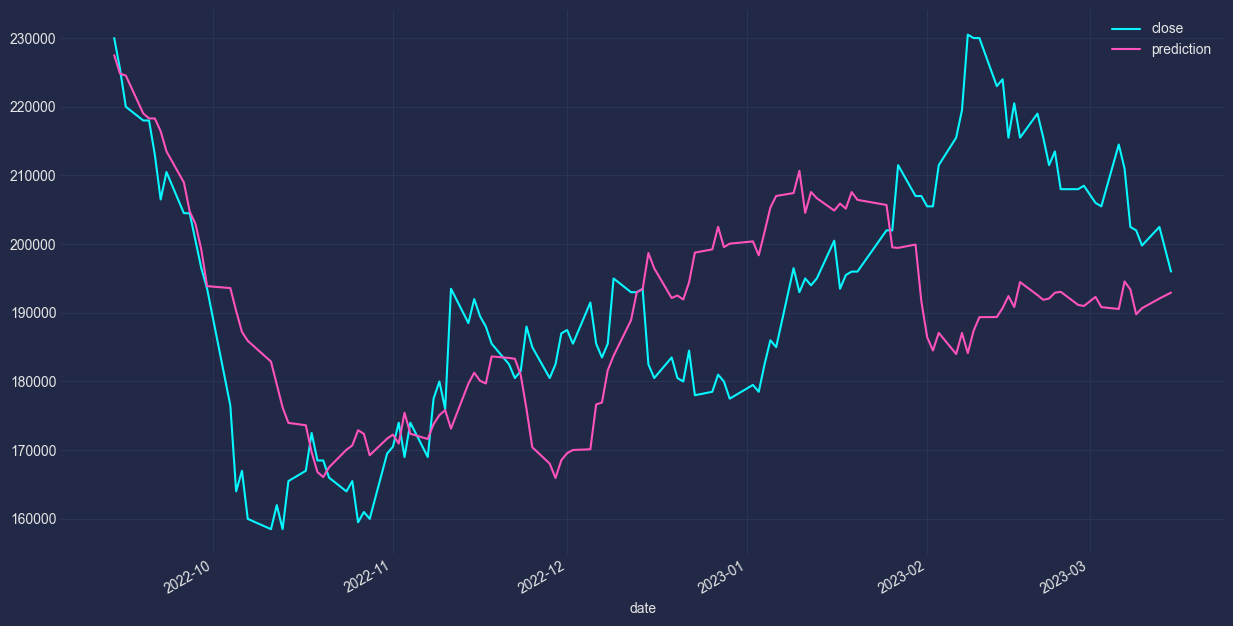

In [47]:
predict_test_df[["close", "prediction"]].plot(figsize=(15, 8))

In [ ]:
data.index = data.index.tz_localize('Asia/Seoul')
predict_test_df.index = predict_test_df.index.tz_localize('Asia/Seoul')

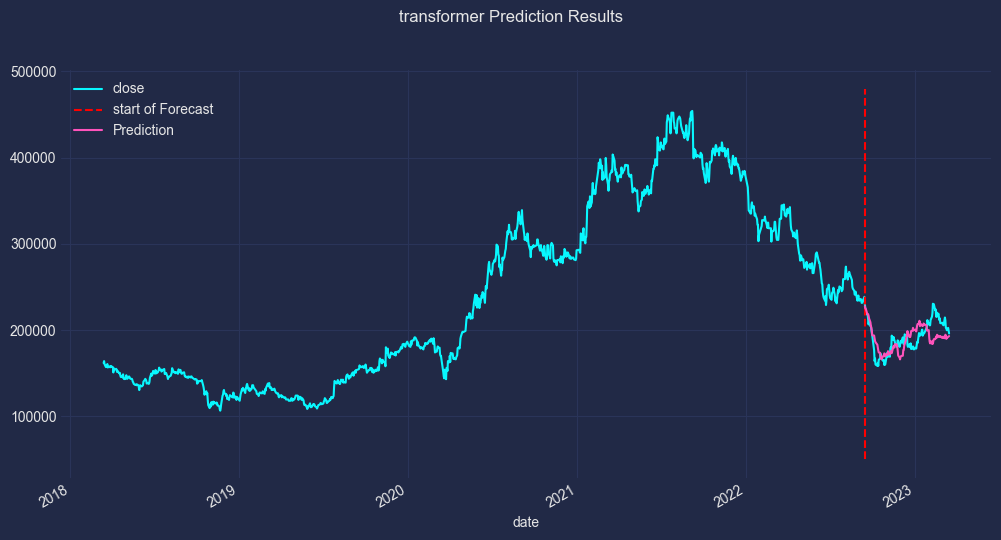

In [97]:
predict_index = predict_test_df.index.to_list()
prediction_values = predict_test_df['prediction'].values.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
data.close.plot(ax=ax);
ax.vlines('2022-09-14', 50000, 480000, linestyle='--', color='r', label='start of Forecast')
ax.plot(predict_index, prediction_values, label='Prediction')
ax.legend(loc='upper left')
plt.suptitle(f'transformer Prediction Results')
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [56]:
test_mae_transformer = mean_absolute_error(predict_test_df['close'].values, predict_test_df['prediction'])
test_rmse_transformer = np.sqrt(mean_squared_error(predict_test_df['close'].values, predict_test_df['prediction']))
test_r2_transformer = r2_score(predict_test_df['close'].values, predict_test_df['prediction'])

print(f"test MAE transformer : {round(test_mae_transformer, 2)}")
print(f"test RMSE transformer : {round(test_rmse_transformer, 2)}")
print(f"test R2 transformer: {round(test_r2_transformer, 2)}")

test MAE transformer : 12851.38
test RMSE transformer : 16099.68
test R2 transformer: 0.24


In [57]:
eval_scores = pd.DataFrame([[round(test_mae_transformer, 2),round(test_rmse_transformer,2), round(test_r2_transformer,2)]],
                            index=['transformer'],
                            columns = ['MAE', 'RMSE', 'R2'])

In [58]:
eval_scores_table = pd.read_csv('eval_scores.csv')
eval_scores_table = eval_scores_table.set_index('Unnamed: 0')
cat_eval = pd.concat([eval_scores_table, eval_scores])

In [91]:
cat_eval

MAE      RMSE    R2
ARIMA         50678.47  53566.43 -7.42
Prophet        7555.16   9610.24  0.73
XGBRegressor  10645.59  14629.09  0.37
transformer   12851.38  16099.68  0.24

In [60]:
#cat_eval.to_csv('eval_scores.csv')

In [61]:
df_eval_table = predict_test_df["prediction"]
# df_eval_table.to_csv('df_eval_table.csv')

In [2]:
df_evals = pd.read_csv('df_eval_table.csv')
#df_evals['transformer'] = df_eval_table.values

In [66]:
#df_evals.to_csv('df_eval_table.csv')

<Axes: >

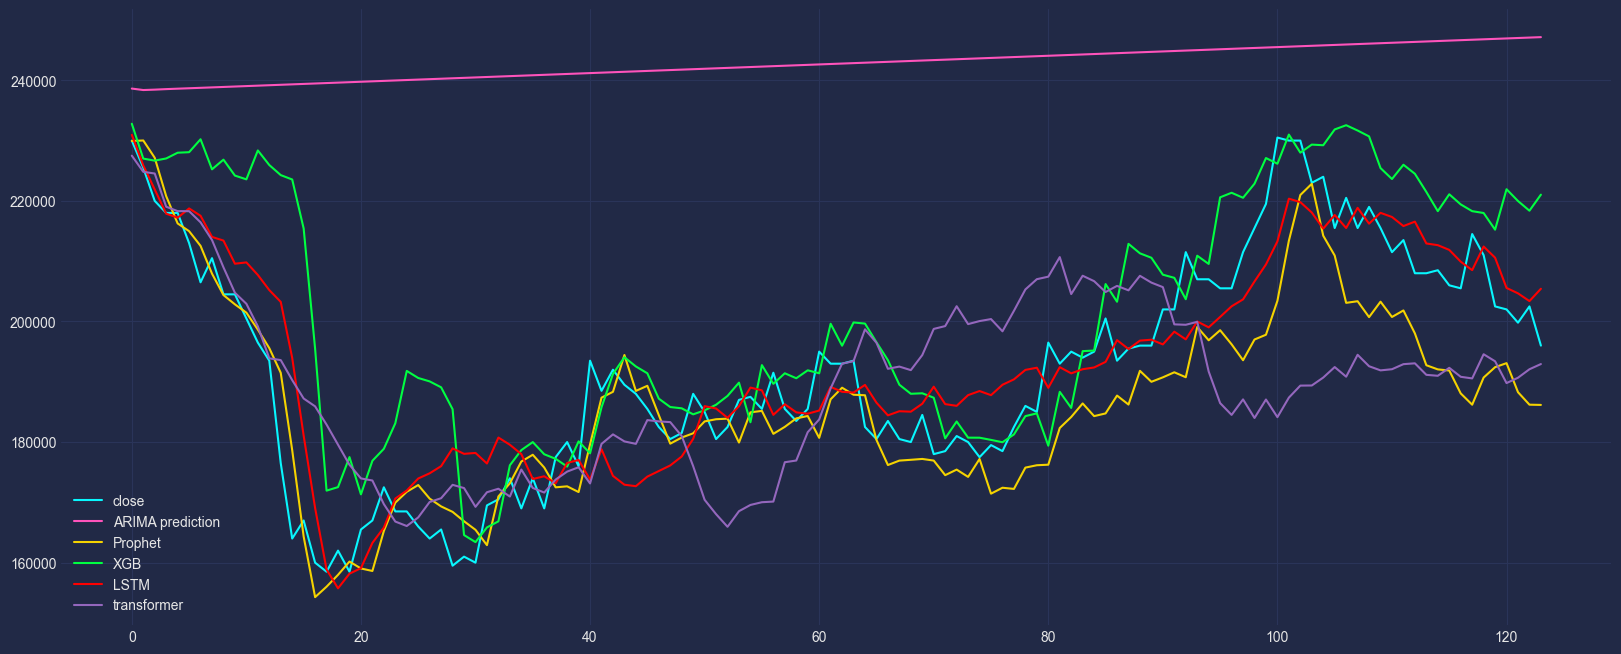

In [3]:
df_evals[["close", "ARIMA prediction", "Prophet", "XGB","LSTM", "transformer"]].plot(figsize=(20, 8))

In [88]:
eval_scores_table = pd.read_csv('eval_scores.csv')

In [94]:
eval_scores_table.drop(eval_scores_table.index[3], axis=0, inplace=True)
eval_scores_table.drop(['R2'], axis=1, inplace=True)

In [124]:
eval_scores_table.rename(columns={'Unnamed: 0':'Model'}, inplace=True)

<Axes: xlabel='Model'>

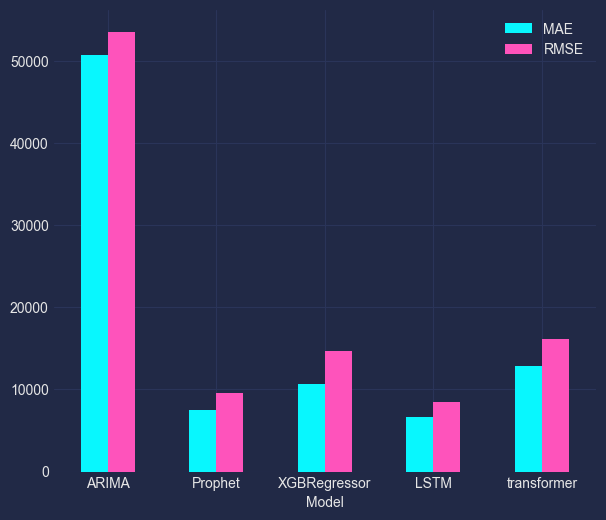

In [158]:
eval_scores_table.set_index('Model').plot(kind="bar",figsize=(7,6), rot=0)

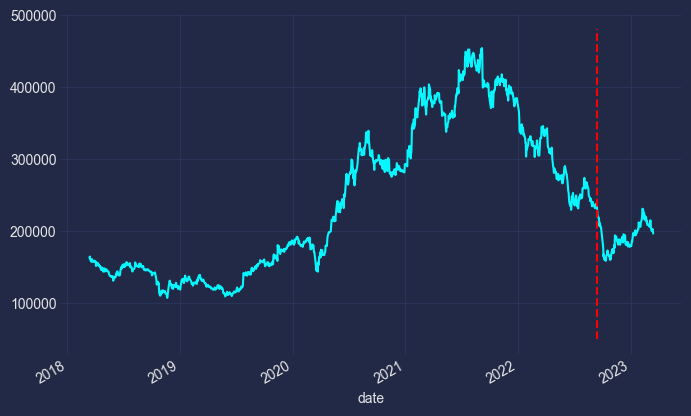

In [161]:
fig, ax = plt.subplots(figsize=(8, 5))
data.close.plot(ax=ax);
ax.vlines('2022-09-14', 50000, 480000, linestyle='--', color='r', label='start of Forecast')
plt.show()

In [22]:
df_evals.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'date', 'close', 'ARIMA prediction', 'Prophet', 'XGB',
       'LSTM', 'transformer'],
      dtype='object')

<Axes: >

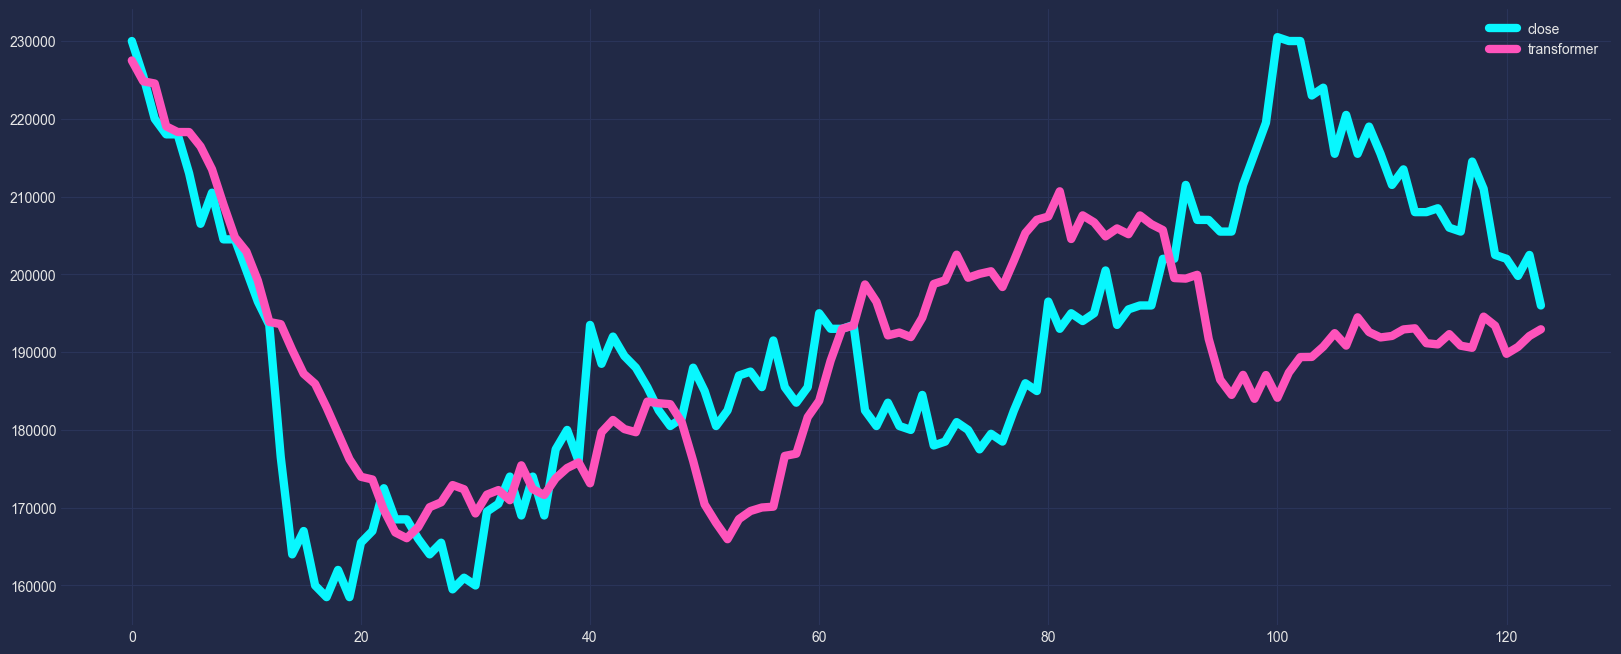

In [45]:
df_evals[["close", "transformer"]].plot(figsize=(20, 8), linewidth="6")